# Using Python to analyze financial data and test automated strategies
Computational Finance, Université de Bordeaux, December 07 and 14, 2018

Nicolas Mauhé ([nicolas.mauhe@u-bordeaux.fr](mailto:nicolas.mauhe@u-bordeaux.fr))

## Table of Contents
1. [Introduction](#Introduction)
2. [Analyzing financial data](#Analyzing-financial-data)
3. [Computing financial indicators](#Computing-financial-indicators)
4. [Designing automated strategies](#Designing-automated-strategies)
1. [Selecting algos](#Selecting-algos)
1. [Customising strategies](#Customising-strategies)
1. [Combining several strategies](#Combining-several-strategies)
1. [Using professional data](#Using-professional-data)
1. [Putting it all into practice](#Putting-it-all-into-practice)
1. [Going further](#Going-further)

## Introduction

Bt is a simple Python package that can be used to fetch financial data, analyze them, establish algorithmic trading strategies, and backtest them. A complete description of the package can be found [here](http://pmorissette.github.io/bt/). It is an open-source package : which means you can access the code behind it on its [github repository](https://github.com/pmorissette/bt). Most of the Python packages work this way : so please get used to using other people work and to reading package documentations, because that is the way Python works. 

Each time you see a cell with some code in it, click on it and then on the "Run" button at the top of the page. You can also click on the cell and then use the shortcut Ctrl + Enter. Feel free to modify every cell and to run them again ! This course is made for you to experiment, and learn how to use Python. So feel free to test anything !

We first import the packages we need:
- bt to do backtesting
- ffn to get financial indicators (bt works on top of it)
- pandas to use data
- numpy to do some math

We can import manually packages downloaded from github using these lines :

In [1]:
import sys
sys.path.insert(0, "./ffn-master/")
import ffn

For general packages, we can install them using our package manager (anaconda, pip, etc.) and import them directly:

In [2]:
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We can change the style of the graphs by using :

In [3]:
plt.style.use('ggplot')

All the styles are available [here](https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html).

Let's start by choosing which stock we want to invest in. We will focus on US equity. We can use any ticker symbol of any US Equity. A list can be found [here](http://eoddata.com/symbols.aspx). Let's choose three companies.

We can use the bt method `bt.get()` to fetch financial data from Yahoo. To know how a method work, we can always use the python method help().

In [ ]:
help(bt.get)

Alternatively, you can use the interrogation point.

In [ ]:
bt.get?

This is a bit "raw", but it can be useful. Another solution is to check the [package documentation](http://pmorissette.github.io/bt/index.html). Here is how to use `bt.get()`:

In [5]:
equity_list = ['AAPL', 'MCD', 'MSFT', 'F']
beginning = '2013-01-01'

In [ ]:
data = bt.get(equity_list, start=beginning)
data.plot()

There we go ! We can now import data from any security, as long as it is available on [Yahoo Finance](https://finance.yahoo.com/).

## Analyzing financial data

We can check the type of this new Python object by using the method type()

In [ ]:
type(data)

It is a dataframe of the package Pandas, the most used Python package to do data analysis.

We can check the Pandas documentation about [dataframes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). Two types of "subobjects" are available for any python object : attributes (fixed objects) and methods (functions). A way to quickly get a list of these in a netbook is to type in the object name followed by a dot and to press TAB.

One can see that some interesting methods are present, such as the one used to plot the data on a graph, plot().

In [ ]:
# Press TAB after "data." and choose plot()


We can also find the method hist(), used to plot an histogram of the values.

In [ ]:
data.hist()

An interesting argument for the drawing methods such as plot() or hist() is the size you want. Just specify figsize = (length, height).

In [ ]:
data.plot(figsize = (15, 10))

Another very useful method is describe(), that gives us summary statistics about the dataset.

In [ ]:
data.describe()

Exercise 1 : find a way to 
1. We have seen how to display the first entries of the DataFrame, using head(). Now let's try to display only the most recent prices (the last items of the dataframe). 
2. Let's plot them....
3. Now, let's plot the evolution of these equities during their last 30 quotes.

Solution (3 commands)

In [ ]:
# 1
data.tail()

In [ ]:
# 2
data.tail().plot()

In [ ]:
# 3
data.tail(30).plot()

## Computing financial indicators

Let's go further. Some useful bt methods are rebase() and to_returns().

In [ ]:
data.rebase().head()

In [ ]:
data.to_returns().head()

The formula of to_returns() is simply $\frac{t_1}{t_2} - 1$.

Exercise 2 : produce the two following plots :
1. The price evolution during the last 30 quotes rebased to 100 at the beginning of the plot.
2. The histogram of the returns of the three equities during last year (252 quotes).

Solution (2 commands)

In [ ]:
# 1 
data.rebase().plot()

In [ ]:
# 2
data.to_returns().tail(252).hist()

Another interesting method available for the data object is corr(). It enables us to compute the correlation matrix of our securities. Let's compute the correlation matrix of the returns.

In [ ]:
data.to_returns().corr()

Another method, plot_corr_heatmap, enable us to get a similar result but using a heatmap.

In [ ]:
data.to_returns().plot_corr_heatmap()

Now, let's see how to display some more complex financial statistics about our data.

In [ ]:
stats = data.calc_stats()
stats.display()

What does it mean ?

- Total Return: Total return on the period.
- Daily Sharpe: Daily Sharpe ratio

The Sharpe ratio : $$S(x) = \frac{R_x - r}{\sigma_x}$$
With $R_x$ being the investment return, $r$ being the riskfree rate and $\sigma_x$ being the standard deviation of the investment.
The Sharpe ratio measures the return you are receiving in comparison with the risk you are taking.

- Daily Sortino: Daily Sortino ratio

The Sortino ratio (as used in the bt package) is a variation of the Sharpe ratio, taking into account only the negative volatility. The formula is very similar :
$$S^{'}(x) = \frac{R_x - r}{\sigma^-_x}$$
With $R_x$ being the investment return, $r$ being the riskfree rate and $\sigma^-_x$ being the downside deviation of the investment.

- CAGR: Compound annual growth rate

The compound annual growth rate (CAGR) :
$${CAGR}(t_0,t_n) = (\frac{V(t_n)}{V(t_0)})^{\frac{1}{t_n-t_0}} - 1$$
It is an easy way to have an idea of the "average" return during the period : taking the actual average of the annual returns is not as good, given that volatility can affect the results.

- Max Drawdown: Maximum decline of the equity
- Calmar Ratio: Ratio of the CAGR and the absolute value of the Max Drawdown

 

 
- Daily Mean (ann.): Daily average of return, times the number of trading periods in a year (252)
- Daily Vol (ann.): Same thing with the standard deviation
- Daily Skew: Usual measure of the asymmetry, daily average
- Daily Kurt: Usual measure of "tailedness", daily average
 
 

 
  
- MTD: The month to date return
- 3m: 3 months ago to date return
- 6m: 6 months
- YTD: The beginning of the year to date return
- 1Y: One year ago to date return
- 3Y: Etc.
- 5Y: Etc.
- 10Y: Be careful : these stats are limited by the data start date !
- Since Incep. (ann.): Same thing !

To get correct statistics (such as Sharpe and Sortino ratios), we have to specify the riskfree rate on the considered period, annualized. To estimate the riskfree rate, The Treasury Bonds rate is used. The different rates available on Yahoo are [here](https://finance.yahoo.com/bonds).

In [15]:
riskfree =  bt.get('^IRX', start=beginning)
riskfree_rate = float(riskfree.mean()) / 100
print(riskfree_rate)

0.005260681816399157


We can now display accurate statistics about our data.

In [ ]:
stats.set_riskfree_rate(riskfree_rate)
stats.display()

Exercise 3:
1. Plot the price evolution of General Electric and Ford since 2013.
2. Display their financial indicators, with a correct riskfree rate.

Solution

In [ ]:
# 1
data_ford_ge = bt.get(['F', 'GE'], start=beginning)
data_ford_ge.plot()

In [ ]:
# 2
stats = data_ford_ge.calc_stats()
stats.set_riskfree_rate(riskfree_rate)
stats.display()

## Designing automated strategies

You can establish strategies in bt in order to choose a portfolio of equities and to automatically ajust this portfolio given a determined strategy. To do so, we will use the bt.Strategy() object.

In [ ]:
help(bt.Strategy)

As we can see, a strategy is a stack of algorithms that work one after the other, transmitting data to each other and / or stop signals. A more complete explanation can be found in the [official documentation](http://pmorissette.github.io/bt/algos.html).

A good structure for a stack of algorithm is the following one :
- frequency : which frequency should your strategy use ?
- selection: which securities should you choose ?
- weighting: how much weight should each of the selected securities have in the target portfolio?
- allocate: close out positions that are no longer needed and allocate capital to those that were selected and given target weights.

Let's take a practical example, making these choices :
- frequency : every month
- selection: all the securities available (in the dataframe)
- weighting: equal weight to all
- allocate: allocate immediately.

In [ ]:
s_equal_weights = bt.Strategy('Equal weights', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

We then run a backtest to assess the efficiency of our automated trading strategy.

In [ ]:
b_equal_weights = bt.Backtest(s_equal_weights, data)
result = bt.run(b_equal_weights)
result.plot()

We can display the same statistics we computed before, this time for the entire portfolio (and its monthly variations).

In [ ]:
result.set_riskfree_rate(riskfree_rate)
result.display()

We can plot the weight variations to have an idea of the algorithm decisions regarding our portfolio.

In [ ]:
b_equal_weights.security_weights.head()

In [ ]:
b_equal_weights.security_weights.iloc[1:].plot()

Exercise 4. Let's compare this strategy to the Standard & Poor's 500 index.
1. Get the S&P index data from [Yahoo](https://finance.yahoo.com/).
2. Create a strategy that only buys S&P index.
3. Create a backtest on the data you fetched.
4. Run it !

Solution

S&P 500 only
0% [############################# ] 100% | ETA: 00:00:00

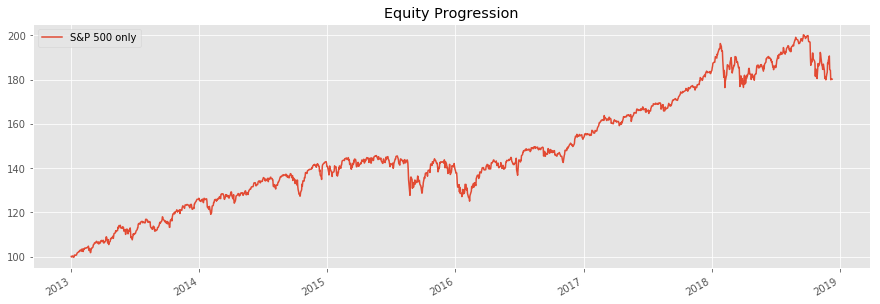

In [8]:
data_sp500 = bt.get('^GSPC', start=beginning)

s_sp500 = bt.Strategy('S&P 500 only', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
                    
b_sp500 = bt.Backtest(s_sp500, data_sp500)
result = bt.run(b_sp500)
result.plot()

## Selecting algos

### Frequency

The frequency can be just once using [RunOnce](http://pmorissette.github.io/bt/bt.html#bt.algos.RunOnce), a specific date using [RunOnDate](http://pmorissette.github.io/bt/bt.html#bt.algos.RunOnDate), or every n periods [RunEveryNPeriods](http://pmorissette.github.io/bt/bt.html#bt.algos.RunEveryNPeriods). The frequency can also be at the beginning of each day, week, month, quarter or year:
- [RunDaily](http://pmorissette.github.io/bt/bt.html#bt.algos.RunDaily)
- [RunWeekly](http://pmorissette.github.io/bt/bt.html#bt.algos.RunWeekly)
- Etc.

### Selection 

Let's see how we can select specific equities based on conditions. The algos we have are

- [SelectAll](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectAll)
- [SelectHasData](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectHasData)
- [SelectMomentum](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectMomentum)
- [SelectN](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectN)
- [SelectRandomly](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectRandomly)
- [SelectThese](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectThese)
- [SelectWhere](http://pmorissette.github.io/bt/bt.html#bt.algos.SelectWhere)

We will use SelectRandomly to conduct a quick experiment. We will choose at random 10 securities among some of the most famous US companies, and invest in them equally.

In [6]:
equity_list = ['AAPL', 'MCD', 'MSFT', 'TGT', 'GE', 'AMZN', 'T', 'UPS', 'GM', 'IBM', 'PEP', 'VZ', 'DIS', 'INTC', 'FORD', 'CMCSA', 'IEF']
data = bt.get(equity_list, start=beginning)
data.head()

,aapl,mcd,msft,tgt,ge,amzn,t,ups,gm,ibm,pep,vz,dis,intc,ford,cmcsa,ief
Date,,,,,,,,,,,,,,,,,
2013-01-02,55.923737,74.569221,23.772734,48.632969,17.364700,257.309998,25.553440,64.044159,23.505007,158.799469,58.252510,33.706596,47.022369,17.766100,1.51,16.246525,95.571938
2013-01-03,55.217865,74.991211,23.454268,49.740898,17.169407,258.480011,25.568039,64.102905,24.061769,157.925995,58.277714,33.546711,47.123600,17.716240,1.64,16.065163,95.080666
2013-01-04,53.679771,74.345810,23.015306,50.088161,17.250782,259.149994,25.721357,64.262360,24.094044,156.890778,58.361729,33.729446,48.025394,17.583284,1.61,16.056725,95.125351
2013-01-07,53.364014,75.222908,22.972277,50.683460,17.193819,268.459991,25.838173,64.077736,23.932665,156.203354,58.353333,34.026379,46.902756,17.658075,1.61,15.985023,95.178955
2013-01-08,53.507637,75.247711,22.851776,50.137768,17.006662,266.380005,25.401876,63.901474,23.698664,155.985001,58.529793,33.198349,46.709503,17.525118,1.62,16.094681,95.411179


Exercise 5 : 
1. Let's build our random strategy. It is the same strategy as before, but this time we use SelectRandomly in our algo stack. We only select 10 securities.
2. Compare this strategy to the S & P Index (run both of them at the same time).

Solution

In [9]:
s_random = bt.Strategy('Random 10', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectRandomly(10),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_random = bt.Backtest(s_random, data)

result = bt.run(b_random, b_sp500)

result.set_riskfree_rate(riskfree_rate)
result.plot()
result.display()

Random 10
0% [############################# ] 100% | ETA: 00:00:00

./ffn-master/ffn/core.py:2153: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


NameError: name 'riskfree_rate' is not defined

Exercise 6 : 
We want to code an algorithm that follow a simple strategy : only invest in the 5 securities that have the highest return, every month, among our list of famous US securities. Write the strategy, and compare it to the random strategy and the S & P index. Did we beat the market ?

Solution

Best 5
0% [############################# ] 100% | ETA: 00:00:00

./ffn-master/ffn/core.py:2153: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


Stat                 Random 10    Best 5      S&P 500 only
-------------------  -----------  ----------  --------------
Start                2013-01-01   2013-01-01  2013-01-01
End                  2018-12-11   2018-12-11  2018-12-11
Risk-free rate       0.53%        0.53%       0.53%

Total Return         85.07%       53.97%      80.21%
Daily Sharpe         0.77         0.51        0.81
Daily Sortino        1.33         0.81        1.26
CAGR                 10.92%       7.53%       10.42%
Max Drawdown         -15.55%      -18.71%     -14.15%
Calmar Ratio         0.70         0.40        0.74

MTD                  -3.32%       -3.19%      -4.47%
3m                   -10.57%      -14.16%     -8.69%
6m                   -5.21%       -14.73%     -5.22%
YTD                  2.76%        -8.88%      -1.38%
1Y                   2.58%        -10.02%     -0.87%
3Y (ann.)            7.27%        4.15%       9.42%
5Y (ann.)            9.32%        6.15%       8.14%
10Y (ann.)           -        

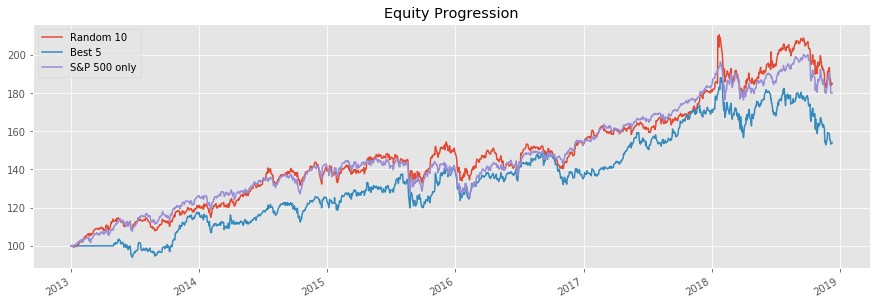

In [21]:
s_best = bt.Strategy('Best 5', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.SelectMomentum(5, lookback=pd.DateOffset(months=3)),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_best = bt.Backtest(s_best, data)

result = bt.run(b_random, b_best, b_sp500)

result.set_riskfree_rate(riskfree_rate)
result.plot()
result.display()

We can specify the lookback period by using a pandas object called DateOffset:

``
lookback=pd.DateOffset(months=3)
``

### Weights

Two basic weighting algorithms :

- [WeighEqually](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighEqually)
- [WeighRandomly](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighRandomly)

Algorithms to customize the weighting : 
- [WeighSpecified](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighSpecified)
- [WeighTarget](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighTarget)

Bt provides two ready-to-go strategies to weigh your portfolio.

- [WeighInvVol](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighInvVol), which weigh the assets proportionally to the inverse of their volatility. "This is a commonly used technique for risk parity portfolios. The least volatile elements receive the highest weight under this scheme."
- [WeighERC](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighERC), in which the weights are designed so each security is contributing in the amount to the portfolio overall volatility.
- [WeighMeanVar](http://pmorissette.github.io/bt/bt.html#bt.algos.WeighMeanVar), which is an implementation of Markowitz’s mean-variance optimization.

Let's try a strategy where we keep all the securities in data and we weigh them using the inverse of their volatility. Let's compare it to the other strategies.

In [ ]:
s_inv = bt.Strategy('Inverse of Volatility', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighInvVol(),
                       bt.algos.Rebalance()])

b_inv = bt.Backtest(s_inv, data)
result = bt.run(b_inv, b_random, b_best, b_sp500)
result.set_riskfree_rate(riskfree_rate)

In [ ]:
result.plot()

In [ ]:
result.display()

What can we conclude ?

Exercise 7 : Create a strategy that will take all the securities and weigh the securities according to Markowitz Mean-Variance portfolio theory. Compare it to the others.

Solution

In [ ]:
s_mark = bt.Strategy('Markowitz', 
                       [bt.algos.RunEveryNPeriods(10, 3),
                       bt.algos.SelectAll(),
                       bt.algos.WeighMeanVar(),
                       bt.algos.Rebalance()])

b_mark = bt.Backtest(s_mark, data)

result = bt.run(b_mark, b_inv, b_random, b_best, b_sp500)
result.set_riskfree_rate(riskfree_rate)

In [ ]:
result.plot()

## Customising strategies

As we have seen, there are two interesting bt.algos that enable us to manually select and attribute weights :
- [SelectWhere](http://pmorissette.github.io/bt/bt.html?#bt.algos.SelectWhere)
- [WeighTarget](http://pmorissette.github.io/bt/bt.html?#bt.algos.WeighTarget)

They take as argument a DataFrame indicating True or False for SelectWhere and the weights for WeighTarget.

Let's start with SelectWhere. We need to give it a boolean DataFrame, which is composed only of True or False.

In [ ]:
data.tail()

In [ ]:
selection = data > 100
selection.tail()

Let's create a strategy based on this boolean DataFrame:

In [ ]:
s_custom_selection = bt.Strategy('Custom selection', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectWhere(selection),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_custom_selection = bt.Backtest(s_custom_selection, data)

In [ ]:
result = bt.run(b_custom_selection)
result.plot_security_weights()

We can use all the price methods in bt (and [ffn](http://pmorissette.github.io)) to change our data and establish interesting conditions. We can also change our data using pandas method. For instance, let's establish the following strategy : we want to invest in securities who are going up.

In [ ]:
data.to_returns().head()

In [ ]:
selection = data.to_returns() > 0
selection.head()

In [ ]:
s_custom_selection = bt.Strategy('Custom selection', 
                       [bt.algos.RunDaily(),
                       bt.algos.SelectWhere(selection),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_custom_selection = bt.Backtest(s_custom_selection, data)
result = bt.run(b_custom_selection, b_sp500)
result.plot()

It does not seem to be a good strategy.

Another possibility is to use the pandas DataFrame method [rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html) to consider moving averages.

In [ ]:
moving_average_data = data.rolling(20).mean()
bt.merge(data.iloc[:,:3], moving_average_data.iloc[:,:3]).plot(figsize = (20, 7))

In [ ]:
selection = data > moving_average_data

In [ ]:
s_custom_selection = bt.Strategy('Custom selection', 
                       [bt.algos.RunDaily(),
                       bt.algos.SelectWhere(selection),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

b_custom_selection = bt.Backtest(s_custom_selection, data)
result = bt.run(b_custom_selection, b_sp500)
result.plot()

Exercise: A classic strategy is to compare a moving average over a long period (50 days for instance) and another moving average over a shorter period, (let's say 15 days). If the more recent moving average is above, then some investors consider it as a signal of an uptrend. 

Apply this strategy to your data, simulate the results: is it efficient ?

Solution

Exercise 8 : You wish to evaluate the volatility of the securities before investing.
1. Compute the dataset with a daily standard deviation over the last 10 periods.
2. Compute the price mean over the last 10 periods, daily.
3. Invest only in equities whose ratio std / mean is below 5% (over the last 10 periods).

Solution

Ok, we can do exactly the same with weights. All we have to do is provide a DataFrame with custom weights. It is a bit more difficult though, because we have to make sure that all the weights sum up to 1. A little trick to transform any value in proportionate weight :

In [ ]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)
print(df)

In [ ]:
print(df.sum(axis=1))

In [ ]:
print(df.div(df.sum(axis=1), axis=0))

Let's apply this to our DataFrame data.

In [ ]:
data.head()

In [ ]:
data.div(data.sum(axis=1), axis=0).head()

We can apply this strategy to any transformation of ou dataframe. For instance, if we take the inverse of the standard deviation, we can create weights from it. Let's compute daily a three month (about 57 quotes) standard deviation.

In [ ]:
std = data.to_returns().rolling(57).std()
std.tail()

Let's take the elementwise inverse (1/element).

In [ ]:
inv_std = 1 / std

We can now build a weight matrix from it.

In [ ]:
inv_std_weights = inv_std.div(inv_std.sum(axis=1), axis=0)
inv_std_weights.tail()

Let's weight our portfolio using this weight matrix ! And let's compare it to the bt algo that does exactly the same thing.

In [ ]:
s_inv = bt.Strategy('Inverse of Volatility', 
                       [bt.algos.RunAfterDays(57),
                       bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighInvVol(),
                       bt.algos.Rebalance()])

b_inv = bt.Backtest(s_inv, data)

In [ ]:
s_custom_weighting = bt.Strategy('Custom weighting', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighTarget(inv_std_weights),
                       bt.algos.Rebalance()])

b_custom_weighting = bt.Backtest(s_custom_weighting, data)

In [ ]:
result = bt.run(b_custom_weighting, b_inv)
result.plot()

We managed to reproduce manually the WeighInv algo.

Exercise 10 : Let's try the opposite strategy ! Invest more in securities that are more volatile (proportionately to their three month standard deviation)

Solution

## Combining several strategies

We can get the price evolution of our portfolio using the attribute "prices" of the backtest result.

In [ ]:
result = bt.run(b_inv, b_sp500)
result.prices.head()

In [ ]:
result.prices.plot(figsize = (15, 5))
result.plot()

Thus we can use it as data to backtest strategies built upon those strategies.

In [ ]:
custom_weights = result.prices * 0 
custom_weights.iloc[:,0] = 0.5
custom_weights.iloc[:,1] = 0.5

In [ ]:
custom_weights.head()

In [ ]:
s_both = bt.Strategy('Half volatility, half S&P', 
                     [bt.algos.RunDaily(),
                      bt.algos.SelectAll(),
                      bt.algos.WeighTarget(custom_weights),
                      bt.algos.Rebalance()])
b_both = bt.Backtest(s_both, result.prices)

In [ ]:
result = bt.run(b_both, b_inv, b_sp500)
result.plot()

This opens a lot of possibilities ! We can have portfolios of a lot of different strategies, and we can design a strategy to select / weight these strategies depending on their performance or their volatility.

## Using professional data

We will now see how to use a more serious data provider, [Quandl](https://www.quandl.com/). Quandl has its own Python package to make fetching data easy. (If you are on your own Python notebook / IDE, please run `pip install quandl`.

In [ ]:
import quandl

A full documentation on how to use quandl is available [here](https://docs.quandl.com/docs).

As all data providers, Quandl needs you to register, and will give you an API key. This is a key you put in your code (Python, R, or any other language). It is used to open the access to the data, and Quandl uses it to monitor your data consumption. A free account is limited. If you want to access top notch data (such as real time data), you will need to pay. We will use a free account.

Once you are on [Quandl](https://www.quandl.com/), click on SIGN IN on the top-right corner and create an account. Quandl will give you your API key straightaway : please copy and paste it below.

In [ ]:
my_api_key = 

Let's tell Quandl our api key.

In [ ]:
quandl.ApiConfig.api_key = my_api_key

Quandl has a method similar to bt.get(). It is quandl.get():

In [ ]:
help(quandl.get)

A more complete documentation can be found [here](https://docs.quandl.com/docs/parameters-2#section-times-series-parameters). It is pretty straightforward. We use it almost the same way we use bt.get(), except quandl has a lot a databases, so we have to specify the database before the ticker symbol. WIKI is the name of the database. 

In [ ]:
data = quandl.get('WIKI/AAPL', start_date = '2016-01-01')
data.head()

To keep things simple, we are only interested in the Close price. We could select the right column in the pandas DataFrame:

In [ ]:
data[['Close']].head()

But this leaves a big data object in our memory, and we will not be using most of it. In the [documentation](https://docs.quandl.com/docs/parameters-2#section-times-series-parameters), we can see that the `column_index` option can be used to select the columns. Here we are only interested in the fourth column.

In [ ]:
data = quandl.get('WIKI/AAPL', start_date = '2016-01-01', column_index = 4)
data.head()

Let's try with our list of equities, `equity_list`.

In [ ]:
print(equity_list)

We need to add the name of database for Quandl to understand what to fetch.

In [ ]:
wiki_equity_list = []
for ticker in equity_list:
    wiki_equity_list.append('WIKI/' + ticker)
print(wiki_equity_list)

Great ! Now we can fetch our data.

In [ ]:
data = quandl.get(wiki_equity_list, start_date = '2016-01-01', column_index = 4)
data.head()

Perfect. If we want to fetch a big number of ticker symbols, it is more convenient to read the list of ticker symbol from a csv file. Here is how to do it.

In [ ]:
big_list = []
import csv
with open('WIKI-datasets-codes.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        big_list.append(row[0])

big_list.pop(1)
big_list.pop(1)
print(big_list[:20])

In [ ]:
data = quandl.get(big_list[:50], start_date = '2016-05-01', column_index = 4)
print(data.head())

Let's clean the missing data.

In [ ]:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, how='all', inplace=True)
print(data.head())

In [ ]:
s1 = bt.Strategy('Best 10', 
                       [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.SelectMomentum(10, lookback = pd.DateOffset(months=2)),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
best10 = bt.Backtest(s1, data)
result = bt.run(best10)
result.plot()

## Putting it all into practice

Choose any data you want, using Yahoo or Quandl (or any provider you want).

Imagine we are the first of January, 2016.

Choose a strategy. Run a backtest on it. Choose the length of the backtest according to your strategey : one month, one year, 5 years...

Then test the strategy from the 1st of January 2016 to now. Did you beat the market ? Why ? What would you change ?

(Please do not cheat and run a lot of strategies until you find one that has good returns. The mark will not depend on the return you achieved !).

## Going further

Now you know how to:
- Use Python;
- Read, run and write IPython Notebooks (= Jupyter Notebooks)
- Import a new package, use `help()` and the documentation to learn everything about the package;
- Use bt and pandas' DataFrames;
- Automatically fetch financial data from a professional source using your own API key;
- Compute basic stats and financial indicators about any equity over any period, and draw nice plots to go with it;
- Design simple and complex automated trading strategies;
- Test them over any period to assess their efficiency.

What you can do to go further:
- Keep on using Python to do things, learn more about it;
- Learn more about Pandas and data structures in Python;
- Learn more about bt to make your strategies a bit more realistic; for instance, you can set up commissions fees that will impact your portfolio returns. You can also use methods surch as [LimitDeltas](http://pmorissette.github.io/bt/bt.html#bt.algos.LimitDeltas) and [LimitWeights](http://pmorissette.github.io/bt/bt.html#bt.algos.LimitWeights) to avoid big changes in your portfolio.
- Discover other BackTesting and trading tools in Python: bt is great to start but more complete tools exist. See [here](https://www.quantstart.com/articles/backtesting-systematic-trading-strategies-in-python-considerations-and-open-source-frameworks) for a review of the possibilities.
- Use everything that your learned to experiment and test what you see in financial courses, in the news or elsewhere: using Python, Pandas and a backtesting tool such as bt, you can write strategies to test most of the theoretical things you can come across. You can use this online notebook to run things, it will remain here for a while.
- Discover the world of algorithmic trading, with different views (technical trading, fundamentalist trading, high frequency arbitrage...). You can have a glance at it thanks to online communities such as [Quantopian](https://www.quantopian.com/posts).
- Need anything ? You can email me at [nicolas.mauhe@u-bordeaux.fr](mailto:nicolas.mauhe@u-bordeaux.fr)